## Chapter 4 (Deep Learning): Two-tower neural Networks

A **two-tower neural network** is an architecture with:

- **Two Separate Towers**: One processes **user-related features** (like ID, behavior, demographics) and the other processes **item-related features** (like ID, metadata).
- **Interaction Layer**: Outputs from both towers are combined (e.g., via dot product) to predict relevance or similarity.

**Use Cases**:
- Recommendation systems.
- Search and retrieval tasks.
- Similarity learning.

**Benefits**: Scalable, computationally efficient, and allows independent feature engineering for users and items.

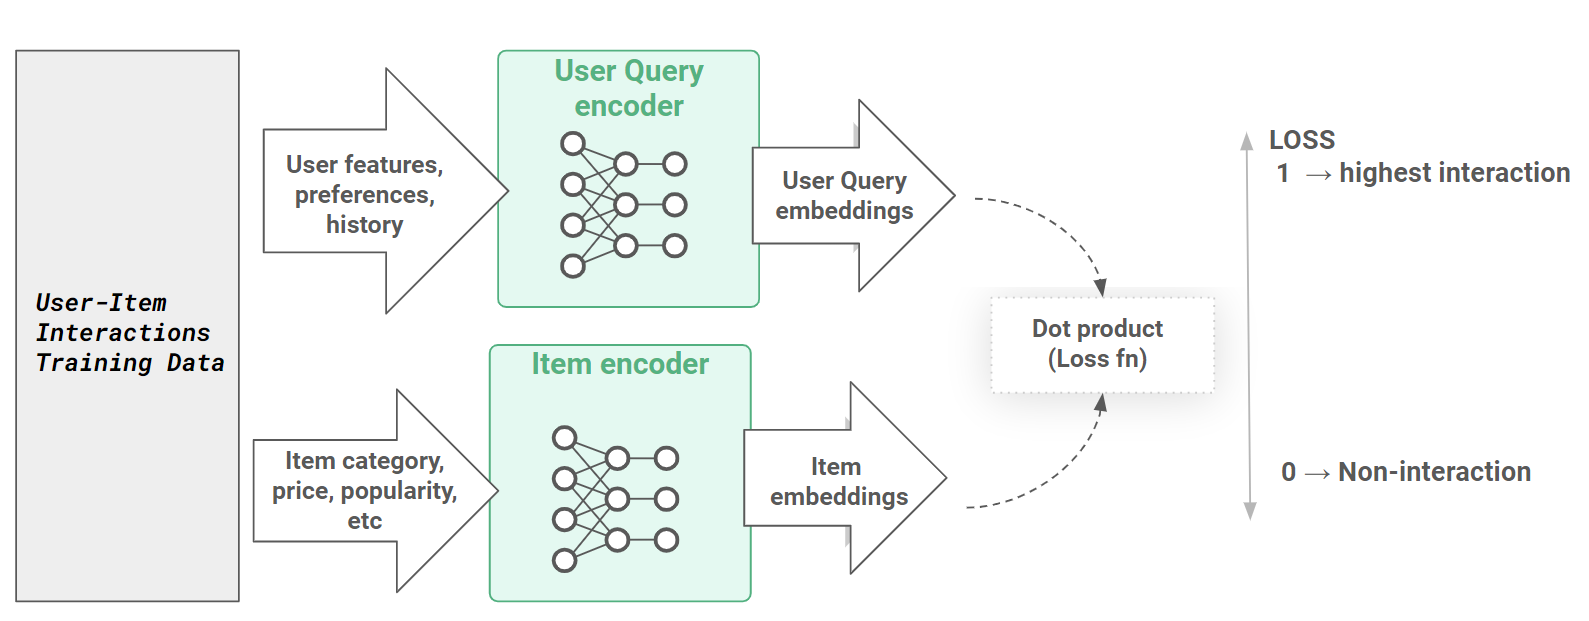

###Importing Libraries

We will build the recommender system using PyTorch. Importing all the relevant dependencies.

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Reading data

Let's read our 3 datasets into the notebook.

In [ ]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv',
                    sep='\t', #Note that the separator here is "\t"
                    encoding='latin-1',
                    engine='python',
                    index_col=0
                     )

# Reading users file
users = pd.read_csv('users.csv',
                    sep='\t', #Note that the separator here is "\t"
                    encoding='latin-1',
                    engine='python',
                    index_col=0
                     )

# # Reading movies file
movies = pd.read_csv('movies.csv',
                    sep='\t', #Note that the separator here is "\t"
                    encoding='latin-1',
                    engine='python',
                    index_col=0
                     )

ratings = ratings.drop(columns=['user_emb_id', 'movie_emb_id']) #We are dropping these columns since they are not needed anymore

### Preparing data for training

Let's define 2 helper functions.

The first function ```encode_titles``` loads a Small Language Model, and convert the movie titles into a vector. This is done since movie titles might tell certain information about the movie.

For instance, StarTrek and Space Odyssey 2 are related to each other semantically and we want to capture that as features in or model.

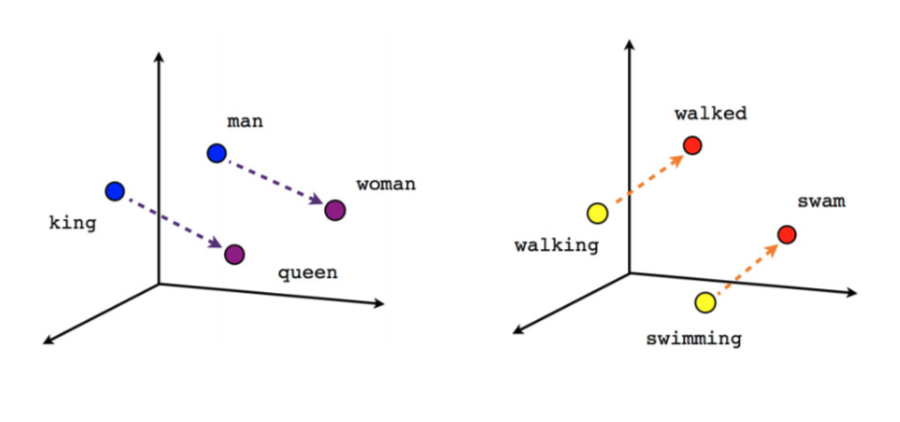




In [ ]:
#This is a function to encode titles. We are importing a language model for sentence transformer
def encode_titles(titles, model_name='all-MiniLM-L6-v2'):
    """
    Encode movie titles using sentence transformer
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode(titles, convert_to_tensor=True)
    return embeddings, model.get_sentence_embedding_dimension()

The below function is a helper function that transforms the data into a tensor that can be consumed by our PyTorch model.

In [ ]:
#Combining a different parts of the dataset that can be transformed through the neural network
def create_dataset_tensors(user_data, movie_data, ratings, title_embeddings):
    """
    Create tensors for the dataset
    """
    return {
        'user_ids': torch.tensor(user_data['user_id'].values, dtype=torch.long),
        'gender': torch.tensor(user_data['gender_encoded'].values, dtype=torch.long),
        'age': torch.tensor(user_data['age'].values, dtype=torch.float),
        'occupation': torch.tensor(user_data['occupation'].values, dtype=torch.long),
        'movie_ids': torch.tensor(movie_data['movie_id'].values, dtype=torch.long),
        'genres': torch.tensor(np.stack(movie_data['genres_encoded']), dtype=torch.float),
        'title_embeddings': title_embeddings,
        'ratings': torch.tensor(ratings, dtype=torch.float)
    }

Let's now do some feature engineering.

We do the following the below cell:
- Map the movies ids and user ids into an id that ranges from 0 to the number of movies/number of users

- We remove the years from the movie titles

- We split up genres into a list

In [ ]:
# Create mappings for movie and user IDs
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(movies['movie_id'].unique()))}
user_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(users['user_id'].unique()))}

# Save the mappings for later use (optional)
movie_id_reverse_map = {v: k for k, v in movie_id_map.items()}
user_id_reverse_map = {v: k for k, v in user_id_map.items()}

# Apply the mappings
movies['movie_id'] = movies['movie_id'].map(movie_id_map)
users['user_id'] = users['user_id'].map(user_id_map)
ratings['movie_id'] = ratings['movie_id'].map(movie_id_map)
ratings['user_id'] = ratings['user_id'].map(user_id_map)

# Verify the mapping worked correctly
print("Movie ID range:", movies['movie_id'].min(), "to", movies['movie_id'].max())
print("User ID range:", users['user_id'].min(), "to", users['user_id'].max())

#Splitting the genres and creating them into a list
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str') #Convert genres to string values

# Process genres
movies['genres'] = movies['genres'].apply(eval)
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True) #Removing years from the movie titles

Movie ID range: 0 to 3882
User ID range: 0 to 6039


In [ ]:
movies.head()

,movie_id,title,genres
0,0,Toy Story,"[Animation, Children's, Comedy]"
1,1,Jumanji,"[Adventure, Children's, Fantasy]"
2,2,Grumpier Old Men,"[Comedy, Romance]"
3,3,Waiting to Exhale,"[Comedy, Drama]"
4,4,Father of the Bride Part II,[Comedy]


Will we do some more processing:

- Convert the titles into embeddings using the SentenceTransformer
- Encode the gender and genres into numerical categories so that the model can consume them easily
- Convert the age into a float

In [ ]:
# Encode titles
title_embeddings, title_embedding_dim = encode_titles(movies['title'].values)

# Process genres
mlb = MultiLabelBinarizer() #MultiLabelBinarizer since a movie ca have multiple geners
genres_encoded = mlb.fit_transform(movies['genres'])
movies['genres_encoded'] = list(genres_encoded)

# Encode categorical variables
gender_encoder = LabelEncoder()
users['gender_encoded'] = gender_encoder.fit_transform(users['gender'])

# Normalize age
users['age'] = users['age'].astype(float)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Let's now do a train-test split and tranform our data into tensors using the dhlper function defined previously.

In [ ]:
# Merge data
data = ratings.merge(users, on='user_id').merge(movies, on='movie_id')

# Split data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Create tensors for train and validation sets
train_tensors = create_dataset_tensors(
    train_data[['user_id', 'gender_encoded', 'age', 'occupation']],
    train_data[['movie_id', 'genres_encoded']],
    train_data['rating'].values / 5.0,
    title_embeddings[train_data.movie_id.values]
)

val_tensors = create_dataset_tensors(
    val_data[['user_id', 'gender_encoded', 'age', 'occupation']],
    val_data[['movie_id', 'genres_encoded']],
    val_data['rating'].values / 5.0,
    title_embeddings[val_data.movie_id.values]
)

model_dims = {
    'n_users': len(users['user_id'].unique()),
    'n_movies': len(movies['movie_id'].unique()),
    'n_genres': genres_encoded.shape[1],
    'n_genders': len(gender_encoder.classes_),
    'n_occupations': users['occupation'].nunique(),
    'title_embedding_dim': title_embedding_dim
}

This is what our train tensor looks like

In [ ]:
train_tensors

{'user_ids': tensor([2506, 4086,   18,  ...,  853, 4032,  785]),
 'gender': tensor([1, 1, 1,  ..., 0, 1, 1]),
 'age': tensor([25.,  1.,  1.,  ..., 25., 25., 25.]),
 'occupation': tensor([ 4,  4, 10,  ..., 16,  6,  0]),
 'movie_ids': tensor([2966, 2771,  453,  ..., 3033, 3410, 1370]),
 'genres': tensor([[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.]]),
 'title_embeddings': tensor([[-0.0244,  0.0173, -0.0897,  ...,  0.0202,  0.0748, -0.1028],
         [ 0.0636,  0.0426, -0.0498,  ..., -0.0501,  0.0509,  0.0515],
         [-0.1107,  0.0124, -0.0301,  ..., -0.0555,  0.0723,  0.0732],
         ...,
         [-0.0648,  0.0110,  0.0240,  ..., -0.0230,  0.0433,  0.0353],
         [-0.0299, -0.0282, -0.0090,  ..., -0.0702,  0.0458, -0.0814],
         [ 0.0241,  0.0483,  0.0407,  ...,  0.0008, -0

### Build the model

Let us now build the model

The movie recommendation model implements a neural collaborative filtering approach with two parallel towers - a User Tower and a Movie Tower - that learn embeddings for users and movies respectively. Here's how the model is structured:

User Tower:
- Takes 4 input features: user_id, gender, occupation, and age
- Processes each feature separately:
  - User ID is embedded into a 64-dimensional space
  - Gender is embedded into a 16-dimensional space
  - Occupation is embedded into a 16-dimensional space
  - Age is normalized by dividing by 100
- These embeddings are concatenated into a 97-dimensional vector
- Passed through a linear layer to produce a 64-dimensional user representation
- Activated using ReLU

Movie Tower:
- Takes 3 input features: movie_id, title, and genres
- Processes each feature:
  - Movie ID is embedded into a 64-dimensional space
  - Title is projected into an embedding space
  - Genre features are processed separately
- These features are concatenated
- Passed through a linear layer to produce a 64-dimensional movie representation
- Activated using ReLU

Final Prediction:
- The 64-dimensional outputs from both towers are concatenated into a 128-dimensional vector
- This is passed through a final linear layer to reduce to dimension 1
- A sigmoid activation is applied to produce the final rating prediction between 0 and 1

The implementation uses PyTorch's nn.Embedding layers for categorical features and nn.Linear layers for transformations. The model processes batches of data efficiently, with separate forward paths for user and movie features before combining them for the final prediction.

This architecture allows the model to learn meaningful representations of both users and items in the same latent space, enabling it to capture complex interactions between user preferences and movie characteristics for making recommendations.

Would you like me to elaborate on any particular aspect of the model architecture or implementation?

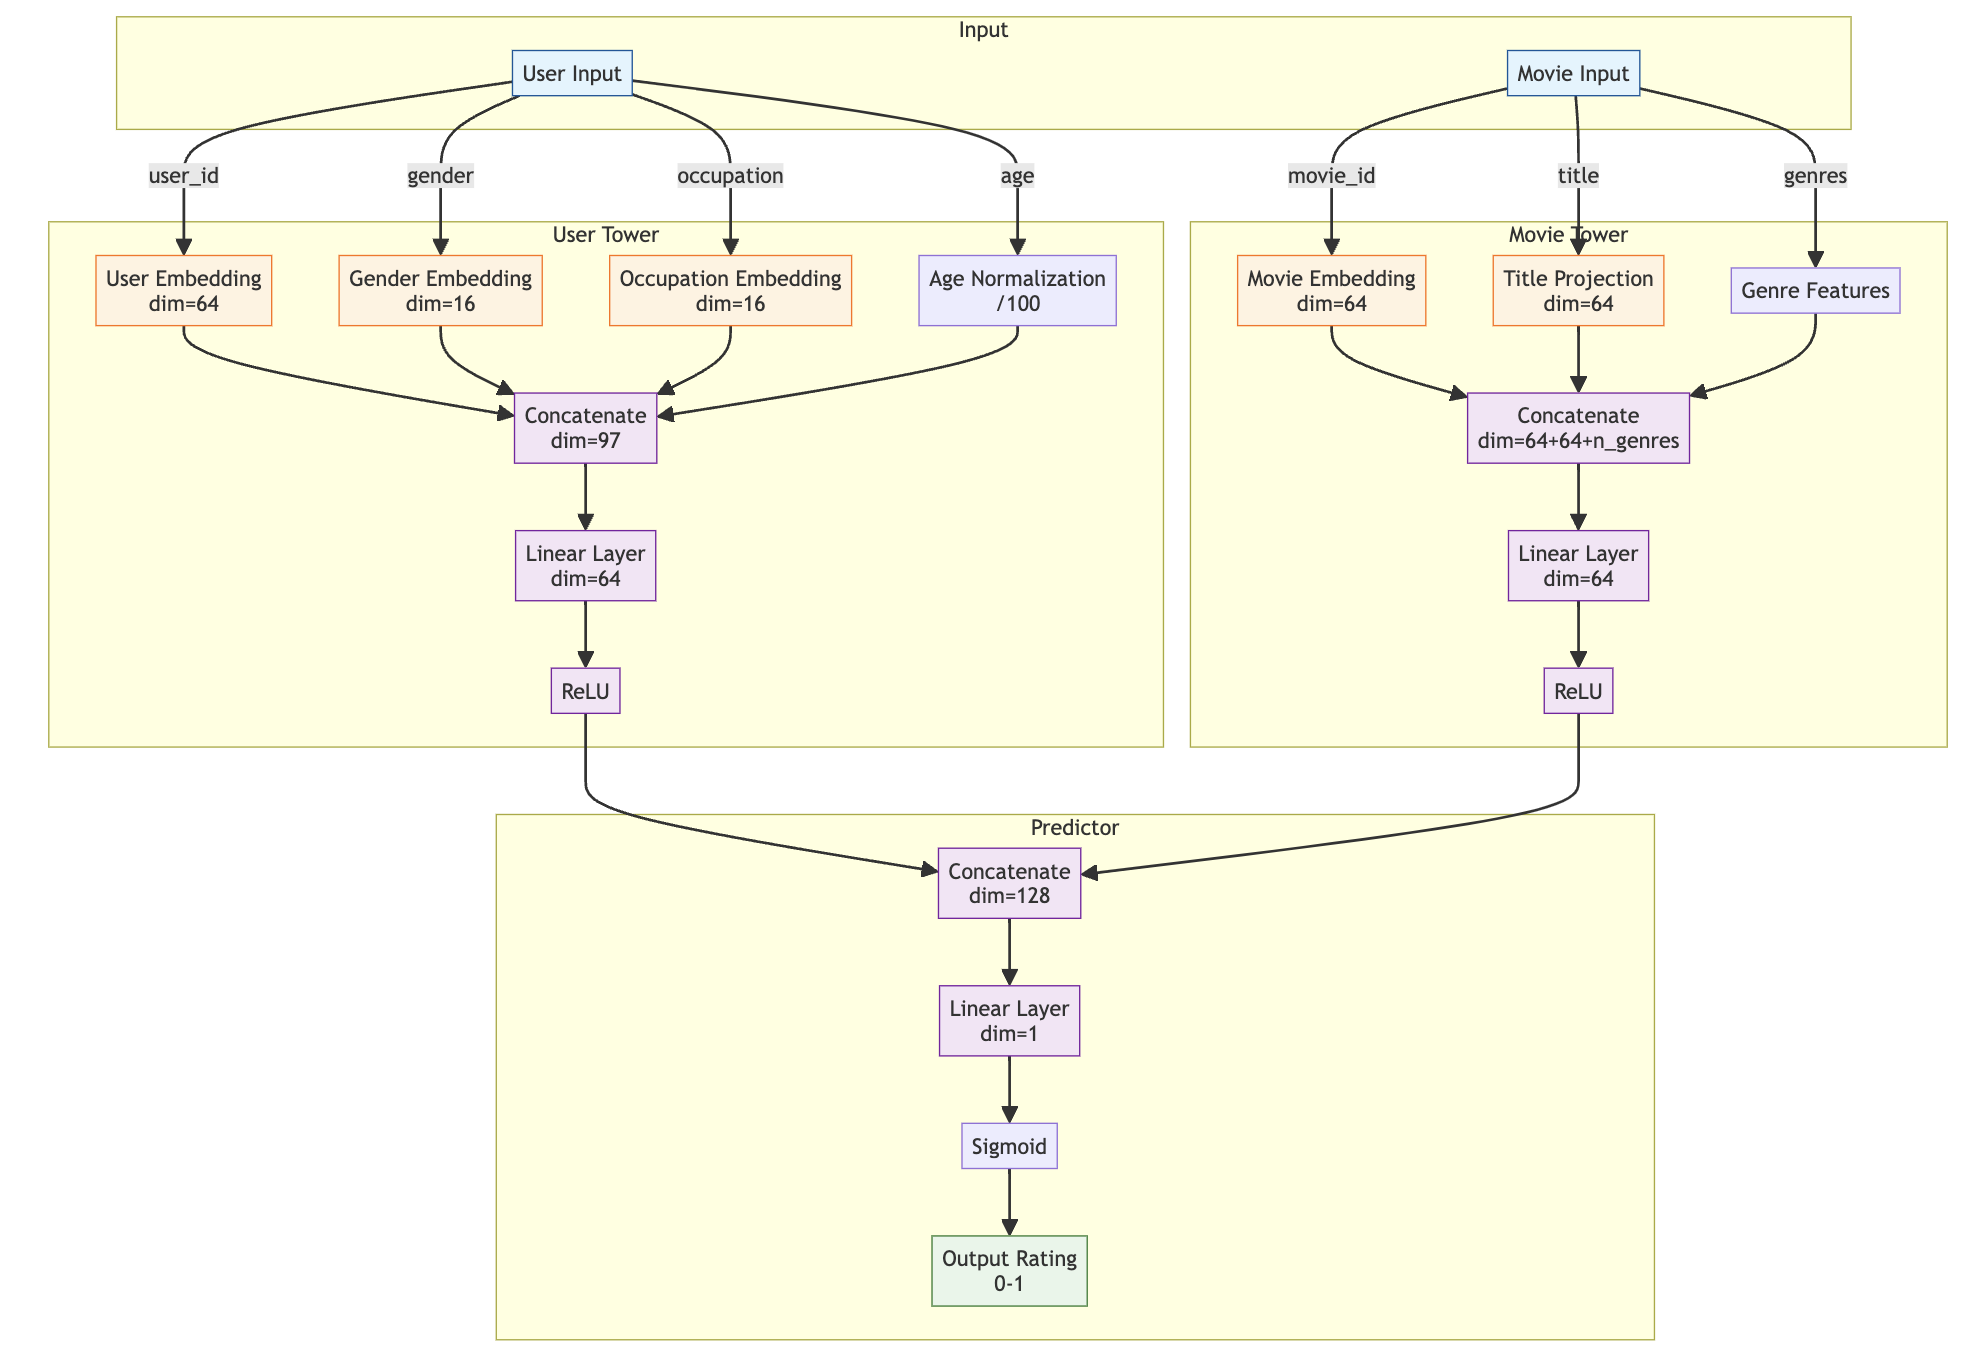

In [ ]:
class TwoTowerNet(nn.Module):
    def __init__(self, n_users, n_movies, n_genres, n_genders, n_occupations,
                 title_embedding_dim, embedding_dim=64):
        super(TwoTowerNet, self).__init__()

        # Print dimensions during initialization
        print(f"Initializing model with dimensions:")
        print(f"n_users: {n_users}")
        print(f"n_movies: {n_movies}")
        print(f"n_genres: {n_genres}")
        print(f"n_genders: {n_genders}")
        print(f"n_occupations: {n_occupations}")
        print(f"title_embedding_dim: {title_embedding_dim}")

        # User embeddings
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.gender_embedding = nn.Embedding(n_genders, embedding_dim // 4)
        self.occupation_embedding = nn.Embedding(n_occupations, embedding_dim // 4)

        # User tower - simplified
        self.user_tower = nn.Sequential(
            nn.Linear(embedding_dim + embedding_dim//4 + embedding_dim//4 + 1, 64),
            nn.ReLU(),
        )

        # Movie embeddings
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        self.title_projection = nn.Linear(title_embedding_dim, embedding_dim)

        # Movie tower - simplified
        self.movie_tower = nn.Sequential(
            nn.Linear(embedding_dim * 2 + n_genres, 64),
            nn.ReLU(),
        )

        # Final prediction - simplified
        self.predictor = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, batch):


        # 1. User embeddings
        user_emb = self.user_embedding(batch['user_ids'])

        gender_emb = self.gender_embedding(batch['gender'])

        occ_emb = self.occupation_embedding(batch['occupation'])

        # 2. Process age
        age = batch['age'].unsqueeze(1) / 100.0


        # 3. Combine user features
        user_features = torch.cat([user_emb, gender_emb, occ_emb, age], dim=1)

        # 4. User tower
        user_vector = self.user_tower(user_features)

        # 5. Movie embeddings
        movie_emb = self.movie_embedding(batch['movie_ids'])

        title_emb = self.title_projection(batch['title_embeddings'])

        # 6. Combine movie features
        movie_features = torch.cat([movie_emb, title_emb, batch['genres']], dim=1)

        # 7. Movie tower
        movie_vector = self.movie_tower(movie_features)

        # 8. Final prediction
        combined = torch.cat([user_vector, movie_vector], dim=1)


        output = self.predictor(combined)
        print("\nFinal output:")
        print(f"Shape: {output.shape}")
        print(f"Contains NaN: {torch.isnan(output).any().item()}")
        print(f"Min: {output.min().item():.4f}, Max: {output.max().item():.4f}")

        return output.squeeze()

### Model Training

The model training process is implemented using PyTorch with the following components:

1. **Training Step Function:**
- Handles single training iterations
- Moves batch data to the specified device (CPU/GPU)
- Performs forward pass, loss computation, and backward pass
- Uses zero_grad() for gradient reset and optimizer step for weight updates
- Includes NaN checking for debugging
- Returns the computed loss for monitoring


2. **Main Training Loop:**
- Initializes the model and moves it to GPU for accelerated training
- Uses MSE Loss as the training criterion
- Implements Adam optimizer with learning rate of 0.001
- Trains for 20 epochs with full dataset passes
- Includes both training and validation phases
- Tracks and stores losses for both phases
- Implements model checkpointing to save best model based on validation loss
- Prints progress and loss metrics for monitoring
- Stores final losses for later visualization

The training process includes proper gradient handling, model state management,
and validation monitoring to ensure effective learning of user-movie interactions.

In [ ]:
def train_step(model, batch, optimizer, criterion, device):
    """Single training step"""
    # Move batch to device and convert to correct types
    batch = {k: v.to(device) for k, v in batch.items()}

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    predictions = model(batch)

    # Print shapes and check for NaNs
    print(f"Predictions shape: {predictions.shape}")
    print(f"Ratings shape: {batch['ratings'].shape}")
    print(f"Contains NaN - Predictions: {torch.isnan(predictions).any()}, Ratings: {torch.isnan(batch['ratings']).any()}")

    # Compute loss
    loss = criterion(predictions, batch['ratings'])

    # Backward pass
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Initialize model and move everything to CPU
model = TwoTowerNet(**model_dims)
model = model.to('cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
best_val_loss = float('inf')

# Lists to store losses
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"epoch: {epoch}")
    # Training
    model.train()

    # Forward pass on entire dataset
    predictions = model(train_tensors)

    # Compute loss
    loss = criterion(predictions, train_tensors['ratings'])

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(val_tensors)
        val_loss = criterion(val_predictions, val_tensors['ratings'])

    # Store losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Training Loss: {loss.item():.4f}')
    print(f'Validation Loss: {val_loss.item():.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, 'best_model.pth')

# Print final losses as JSON format for visualization
print("\nTraining Losses:", train_losses)
print("Validation Losses:", val_losses)

Initializing model with dimensions:
n_users: 6040
n_movies: 3883
n_genres: 18
n_genders: 2
n_occupations: 21
title_embedding_dim: 384
epoch: 0

Final output:
Shape: torch.Size([800167, 1])
Contains NaN: False
Min: 0.3196, Max: 0.6724

Final output:
Shape: torch.Size([200042, 1])
Contains NaN: False
Min: 0.3343, Max: 0.6755
Epoch 1/20:
Training Loss: 0.0970
Validation Loss: 0.0892
epoch: 1

Final output:
Shape: torch.Size([800167, 1])
Contains NaN: False
Min: 0.3363, Max: 0.6876

Final output:
Shape: torch.Size([200042, 1])
Contains NaN: False
Min: 0.3552, Max: 0.6922
Epoch 2/20:
Training Loss: 0.0889
Validation Loss: 0.0820
epoch: 2

Final output:
Shape: torch.Size([800167, 1])
Contains NaN: False
Min: 0.3532, Max: 0.7026

Final output:
Shape: torch.Size([200042, 1])
Contains NaN: False
Min: 0.3766, Max: 0.7097
Epoch 3/20:
Training Loss: 0.0816
Validation Loss: 0.0755
epoch: 3

Final output:
Shape: torch.Size([800167, 1])
Contains NaN: False
Min: 0.3701, Max: 0.7198

Final output:
Shap

Let us know plot the **Train and Validation Loss Curves**

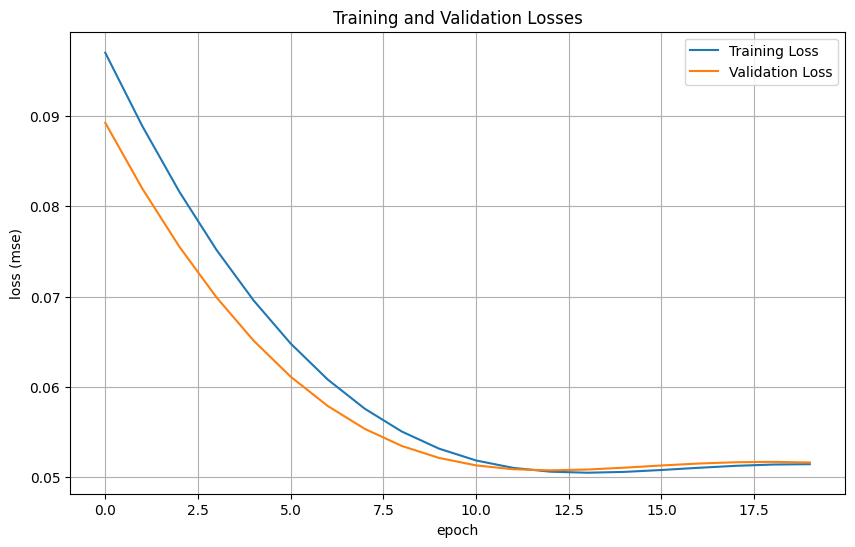

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

### Inference

This section implements the movie recommendation system using the trained model:

1. **Model Loading and Setup**:
- Loads the best performing model from saved checkpoint
- Sets model to evaluation mode for inference

2. **Movie Similarity Search**:
- Takes a query movie title as input
- Retrieves movie information from the dataset
- Uses the model's learned representations to find similar movies by:
  * Computing embeddings for all movies using the Movie Tower
  * Combining movie ID embeddings, title projections, and genre features
  * Calculating cosine similarity between the query movie and all other movies
  * Excluding the query movie from recommendations
  * Selecting top 5 most similar movies

3. **Recommendation Output**:
- Displays the query movie's information (title and genres)
- Lists 5 recommended movies with their:
  * Titles
  * Genres
  * (Optional) Similarity scores

The recommendations are based on the model's learned representations of movies,
capturing similarities in terms of content (genres) and latent features learned
during training.

**Usage**:
- Modify 'query_title' variable to get recommendations for different movies
- Ensure the movie title matches exactly with the database entry

In [ ]:
import torch.nn.functional as F

def get_similar_movies(model, movie_id, movies, title_embeddings, n=5):
    """
    Find similar movies using a combination of movie embeddings, title embeddings, and genre features.

    Args:
        model: Trained recommendation model
        movie_id: ID of the query movie
        movies: DataFrame containing movie information
        title_embeddings: Pre-computed title embeddings
        n: Number of similar movies to return (default=5)

    Returns:
        tuple: (indices of similar movies, similarity scores)
    """

    # Disable gradient computation for inference
    with torch.no_grad():
        # Generate embeddings for all movies

        # Create tensor with all movie IDs (0 to number of movies - 1)
        all_movie_ids = torch.arange(len(movies))

        # Get movie ID embeddings from the trained model
        movie_emb = model.movie_embedding(all_movie_ids)

        # Project title embeddings using trained projection layer
        title_emb = model.title_projection(title_embeddings)

        # Convert genre features to tensor, stacking all movies' genres
        genres = torch.tensor(np.stack(movies['genres_encoded']), dtype=torch.float)

        # Normalize all features to unit length for cosine similarity
        movie_emb = F.normalize(movie_emb, p=2, dim=1)  # L2 normalize movie embeddings
        title_emb = F.normalize(title_emb, p=2, dim=1)  # L2 normalize title embeddings
        genres = F.normalize(genres, p=2, dim=1)        # L2 normalize genre features

        # Calculate similarities for each feature type separately

        # Compute similarity between query movie's ID embedding and all movies
        embedding_similarities = F.cosine_similarity(
            movie_emb[movie_id].unsqueeze(0),  # Add batch dimension to query
            movie_emb                          # All movie embeddings
        )

        # Compute similarity between query movie's title embedding and all movies
        title_similarities = F.cosine_similarity(
            title_emb[movie_id].unsqueeze(0),  # Add batch dimension to query
            title_emb                          # All title embeddings
        )

        # Compute similarity between query movie's genres and all movies
        genre_similarities = F.cosine_similarity(
            genres[movie_id].unsqueeze(0),     # Add batch dimension to query
            genres                             # All genre features
        )

        # Combine all similarity scores with equal weights
        # Could be modified to use different weights for each similarity type
        similarities = (
            embedding_similarities +   # Similarity from learned movie embeddings
            genre_similarities +      # Similarity from genre features
            title_similarities       # Similarity from title embeddings
        )

        # Print combined similarities for debugging/monitoring
        print(similarities)

        # Set similarity with query movie to -1 to exclude it from recommendations
        similarities[movie_id] = -1

        # Get top N most similar movies
        top_scores, top_indices = torch.topk(similarities, n)

        # Return the indices and scores of similar movies
        return top_indices, top_scores

In [ ]:
indices, scores = get_similar_movies(model, 256, movies, title_embeddings, n=5)
for idx, score in zip(indices.tolist(), scores.tolist()):
        similar_movie = movies.iloc[idx]
        print(f"Movie: {similar_movie['title']}")
        print(f"Genres: {similar_movie['genres']}")
        # print(f"Similarity Score: {score.item():.2f}")
        print("-" * 60)

tensor([0.7615, 0.8085, 0.7584,  ..., 1.5820, 1.6784, 1.7273])
Movie: Sling Blade
Genres: ['Drama', 'Thriller']
------------------------------------------------------------
Movie: Rounders
Genres: ['Crime', 'Drama']
------------------------------------------------------------
Movie: Amateur
Genres: ['Crime', 'Drama', 'Thriller']
------------------------------------------------------------
Movie: Gloria
Genres: ['Drama', 'Thriller']
------------------------------------------------------------
Movie: Kiss the Girls
Genres: ['Crime', 'Drama', 'Thriller']
------------------------------------------------------------


In [ ]:
def predict_user_movie_rating(model, user_id, movie_id, users, movies, title_embeddings):
    """
    Predict rating for a specific user-movie pair using the trained model

    Args:
        model: Trained TwoTowerNet model for recommendation
        user_id: Original user ID from dataset (before any mapping)
        movie_id: Original movie ID from dataset (before any mapping)
        users: DataFrame containing user information
        movies: DataFrame containing movie information
        title_embeddings: Pre-computed embeddings for movie titles

    Returns:
        float: Predicted rating on a 0-5 scale
    """

    # Set model to evaluation mode (disables dropout, batch norm, etc.)
    model.eval()

    # Retrieve user information from users DataFrame
    user = users[users['user_id'] == user_id].iloc[0]

    # Retrieve movie information from movies DataFrame
    movie = movies[movies['movie_id'] == movie_id].iloc[0]

    # Create a batch dictionary with all required input tensors
    # Each tensor has shape [1, feature_dim] for single prediction
    batch = {
        # User features
        'user_ids': torch.tensor([user['user_id']], dtype=torch.long),        # User ID
        'gender': torch.tensor([user['gender_encoded']], dtype=torch.long),    # Encoded gender
        'age': torch.tensor([user['age']], dtype=torch.float),                # Normalized age
        'occupation': torch.tensor([user['occupation']], dtype=torch.long),    # Encoded occupation

        # Movie features
        'movie_ids': torch.tensor([movie['movie_id']], dtype=torch.long),     # Movie ID
        'genres': torch.tensor([movie['genres_encoded']], dtype=torch.float),  # Encoded genres
        'title_embeddings': title_embeddings[movie['movie_id']].unsqueeze(0)  # Title embedding with batch dimension
    }

    # Generate prediction without computing gradients
    with torch.no_grad():
        prediction = model(batch)

    # Convert model output (0-1) to rating scale (0-5)
    rating = prediction.item() * 5

    return rating

In [ ]:

def get_top_recommendations(model, user_id, users, movies, title_embeddings, n=5):
    """
    Get top N movie recommendations for a specific user

    Args:
        model: Trained recommendation model
        user_id: User to generate recommendations for
        users: Users DataFrame
        movies: Movies DataFrame
        title_embeddings: Pre-computed title embeddings
        n: Number of recommendations to return (default=5)

    Returns:
        list: Top N recommendations as (title, predicted_rating, genres) tuples
    """
    predictions = []

    # Get list of movies the user has already rated
    user_movies = ratings[ratings['user_id'] == user_id]['movie_id']

    # Iterate through all movies
    for idx, movie in movies.iterrows():
        # Only predict for movies the user hasn't rated yet
        if movie['movie_id'] not in user_movies.values:
            # Get prediction for this user-movie pair
            rating = predict_user_movie_rating(model, user_id, movie['movie_id'],
                                            users, movies, title_embeddings)

            # Store movie information and predicted rating
            predictions.append((movie['title'], rating, movie['genres']))

    # Sort predictions by rating (descending) and get top N
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]

    return recommendations

In [ ]:
recommendations = get_top_recommendations(model, 1, users, movies, title_embeddings, n=5)

Streaming output truncated to the last 5000 lines.

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7457, Max: 0.7457

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7074, Max: 0.7074

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7029, Max: 0.7029

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7639, Max: 0.7639

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7270, Max: 0.7270

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7508, Max: 0.7508

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.6986, Max: 0.6986

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7390, Max: 0.7390

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7677, Max: 0.7677

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7001, Max: 0.7001

Final output:
Shape: torch.Size([1, 1])
Contains NaN: False
Min: 0.7410, Max: 0.7410

Fi

In [ ]:
recommendations

[('Greatest Show on Earth, The', 3.9138099551200867, ['Drama']),
 ('Edward Scissorhands', 3.889693319797516, ['Drama', 'Romance']),
 ('Godfather: Part II, The', 3.883667290210724, ['Action', 'Crime', 'Drama']),
 ('Immortal Beloved', 3.8690215349197388, ['Drama', 'Romance']),
 ('Shadow of a Doubt', 3.8641688227653503, ['Film-Noir', 'Thriller'])]